In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz')
features = ['date_time', 'holiday', 'temp', 'traffic_volume']
data = data[features]
data['date_time'] = pd.to_datetime(data['date_time'])
data

,date_time,holiday,temp,traffic_volume
0,2012-10-02 09:00:00,NaN,288.28,5545
1,2012-10-02 10:00:00,NaN,289.36,4516
2,2012-10-02 11:00:00,NaN,289.58,4767
3,2012-10-02 12:00:00,NaN,290.13,5026
4,2012-10-02 13:00:00,NaN,291.14,4918
...,...,...,...,...
48199,2018-09-30 19:00:00,NaN,283.45,3543
48200,2018-09-30 20:00:00,NaN,282.76,2781
48201,2018-09-30 21:00:00,NaN,282.73,2159
48202,2018-09-30 22:00:00,NaN,282.09,1450


# EDA

In [3]:
data.describe()

,date_time,temp,traffic_volume
count,48204,48204.000000,48204.000000
mean,2016-01-05 10:46:16.773711616,281.205870,3259.818355
min,2012-10-02 09:00:00,0.000000,0.000000
25%,2014-02-06 11:45:00,272.160000,1193.000000
50%,2016-06-11 03:30:00,282.450000,3380.000000
75%,2017-08-11 06:00:00,291.806000,4933.000000
max,2018-09-30 23:00:00,310.070000,7280.000000
std,NaN,13.338232,1986.860670


In [4]:
data = data.drop_duplicates()
data = data.drop_duplicates(subset='date_time')

Зарполняем пропуски

In [5]:
full_time_range = pd.date_range(start=data['date_time'].min(), end=data['date_time'].max(), freq='H')
data.set_index('date_time', inplace=True)
data = data.reindex(full_time_range).reset_index()
data = data.rename(columns={'index': 'date_time'})
data

,date_time,holiday,temp,traffic_volume
0,2012-10-02 09:00:00,NaN,288.28,5545.0
1,2012-10-02 10:00:00,NaN,289.36,4516.0
2,2012-10-02 11:00:00,NaN,289.58,4767.0
3,2012-10-02 12:00:00,NaN,290.13,5026.0
4,2012-10-02 13:00:00,NaN,291.14,4918.0
...,...,...,...,...
52546,2018-09-30 19:00:00,NaN,283.45,3543.0
52547,2018-09-30 20:00:00,NaN,282.76,2781.0
52548,2018-09-30 21:00:00,NaN,282.73,2159.0
52549,2018-09-30 22:00:00,NaN,282.09,1450.0


Добавим признаки

In [6]:
data['day_of_week'] = data['date_time'].dt.day_of_week
data['hour_of_day'] = data['date_time'].dt.hour
data['month']       = data['date_time'].dt.month

Заполним пропуски в трафике и погоде

In [7]:
means = data.groupby(['month', 'day_of_week', 'hour_of_day'])['traffic_volume'].mean()
means_temp = data.groupby(['month', 'day_of_week', 'hour_of_day'])['temp'].mean()

# Функция для заполнения пропусков
@np.vectorize
def fill_na_volume(value, month, day_of_week, hour_of_day):
    if pd.isna(value):
        return means.loc[month, day_of_week, hour_of_day] + np.random.uniform(0, 300)
    else:
        return value

@np.vectorize
def fill_na_temp(value, month, day_of_week, hour_of_day):
    if pd.isna(value) or not value:
        return means_temp.loc[month, day_of_week, hour_of_day] + np.random.uniform(-5, 5)
    else:
        return value

data['traffic_volume'] = fill_na_volume(data['traffic_volume'], data['month'], data['day_of_week'], data['hour_of_day'])
data['temp']           = fill_na_temp(data['temp'], data['month'], data['day_of_week'], data['hour_of_day'])

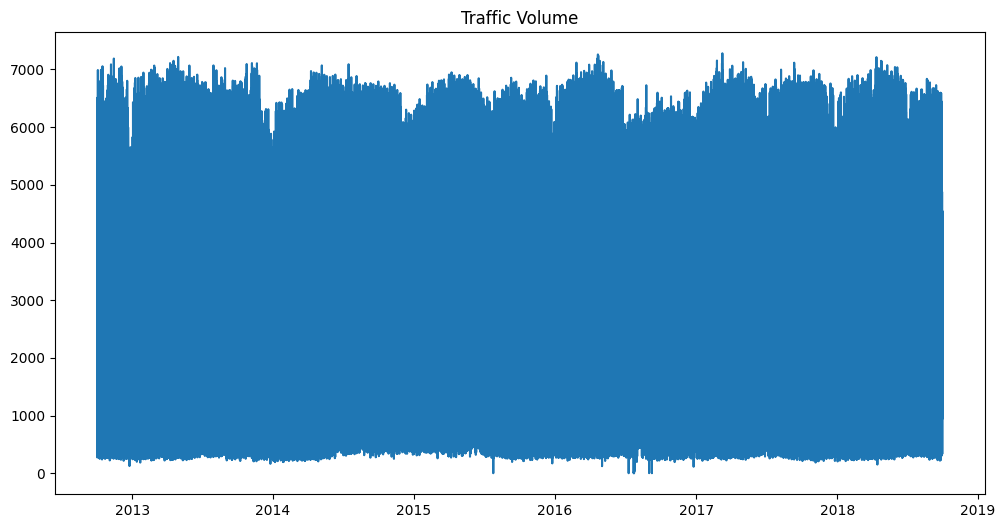

In [8]:
# Построение графика траффика
plt.figure(figsize=(12, 6))
plt.plot(data['date_time'], data['traffic_volume'])
plt.title('Traffic Volume')
plt.show()

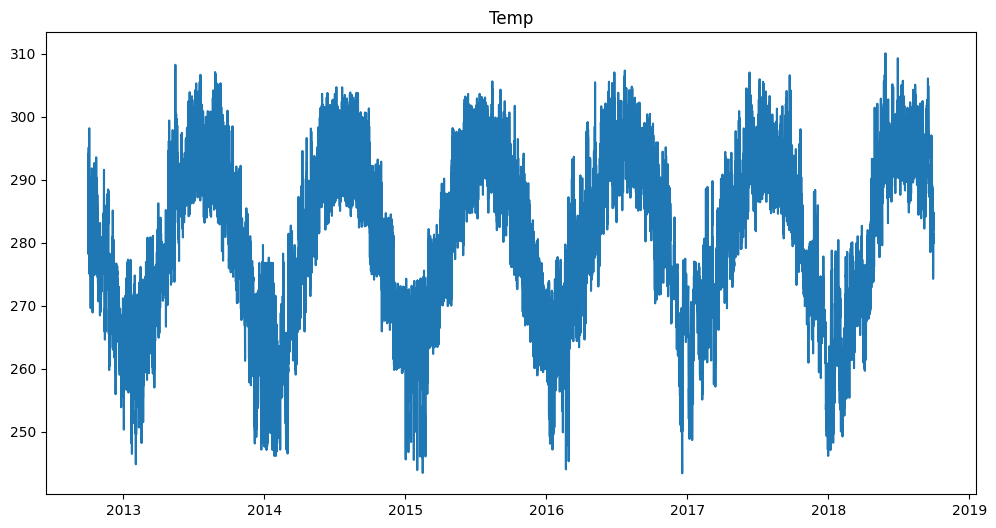

In [9]:
# Построение графика погоды
plt.figure(figsize=(12, 6))
plt.plot(data['date_time'], data['temp'])
plt.title('Temp')
plt.show()

In [10]:
data = data.interpolate()

 Добавим лаги за прошлые 24 часа для регрессионных моделей

In [11]:
for i in range(1, 25):
    data[f'lag_{i}'] = data['traffic_volume'].shift(i)
# уберем строки с NaN  лагами
data = data[24:]

Закодируем является ли день праздником

In [12]:
data['holiday'] = np.where(data['holiday'].isna(), 0, 1)

Сделаем Train Test

In [13]:
test_start_data = data['date_time'].max() - pd.Timedelta(days=14)
train_data = data[data['date_time'] < test_start_data]
test_data = data[data['date_time'] >= test_start_data]

ADF Statistic: -34.126373
p-value: 0.000000
Critical Values:
   1%, -3.4304746401608064
Critical Values:
   5%, -2.8615950884484134
Critical Values:
   10%, -2.566799321749207


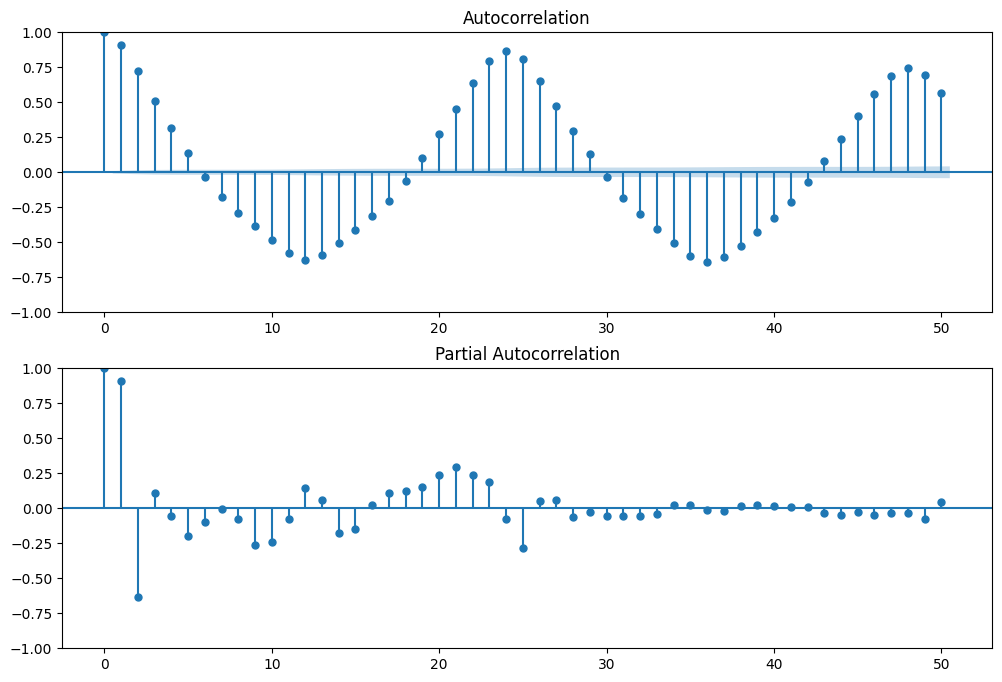

In [14]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера
result = adfuller(data['traffic_volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Построение ACF и PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12, 8))
plot_acf(data['traffic_volume'], lags=50, ax=ax[0])
plot_pacf(data['traffic_volume'], lags=50, ax=ax[1])
plt.show()

Критерий Дики-Фуллера показывает, что ряд является стационарным.  
Автокорреляционная функция намекает на сезонность в нашем временном ряде

Функция для расчета ошибок

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def error(y_true, y):
    print('MAE:', mean_absolute_error(y_true, y))
    print('MSE:', mean_squared_error(y_true, y, squared=False))

def plot(prediction, label):
    plt.figure(figsize=(15, 5))
    plt.plot(test_data['date_time'], test_data['traffic_volume'], label='Actual')
    plt.plot(test_data['date_time'], prediction, label=f'{label} Prediction')
    plt.title(f'{label} Model Predictions vs Actual Values')
    plt.xlabel('Date Time')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.show()

def plot_temp(prediction, label):
    plt.figure(figsize=(15, 5))
    plt.plot(test_data['date_time'], test_data['temp'], label='Actual')
    plt.plot(test_data['date_time'], prediction, label=f'{label} Prediction')
    plt.title(f'{label} Model Predictions vs Actual Values')
    plt.xlabel('Date Time')
    plt.ylabel('Temp')
    plt.legend()
    plt.show()
 

# Baseline

In [16]:
baseline_predict = train_data.groupby(['day_of_week', 'hour_of_day'])['traffic_volume'].mean().reset_index()
test_data = test_data.merge(baseline_predict, on=['day_of_week', 'hour_of_day'], suffixes=('', '_predicted_baseline'))

In [17]:
error(test_data['traffic_volume'], test_data['traffic_volume_predicted_baseline'])

MAE: 206.4917213485824
MSE: 295.9439569511258


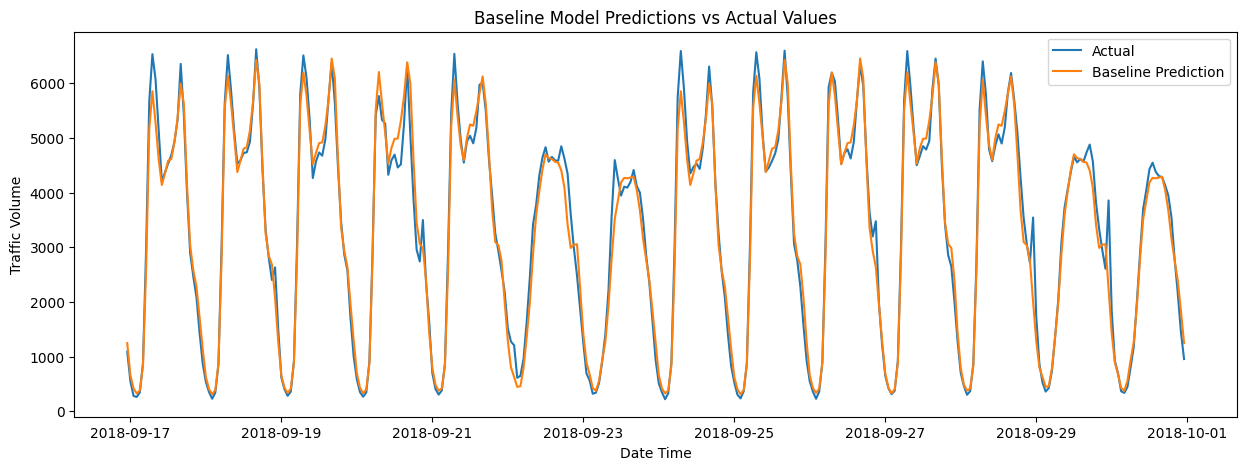

In [18]:
plot(test_data['traffic_volume_predicted_baseline'], label='Baseline')

# SARIMA

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# уменьшим train т.к. не хватает оперативы

sarima_train_data = train_data['traffic_volume'][-1500:]

sarima = SARIMAX(sarima_train_data, order=(0,0,0), seasonal_order=(0,1,0,24*7)).fit()

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70899D+00    |proj g|=  2.58033D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   2.738D-06   6.706D+00
  F =   6.7057298555041438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [20]:
sarima_pred = sarima.predict(start=len(sarima_train_data), end=len(sarima_train_data) + len(test_data)-1, dynamic=False)

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
error(test_data['traffic_volume'], sarima_pred)

MAE: 204.25816023738872
MSE: 340.4390558408946


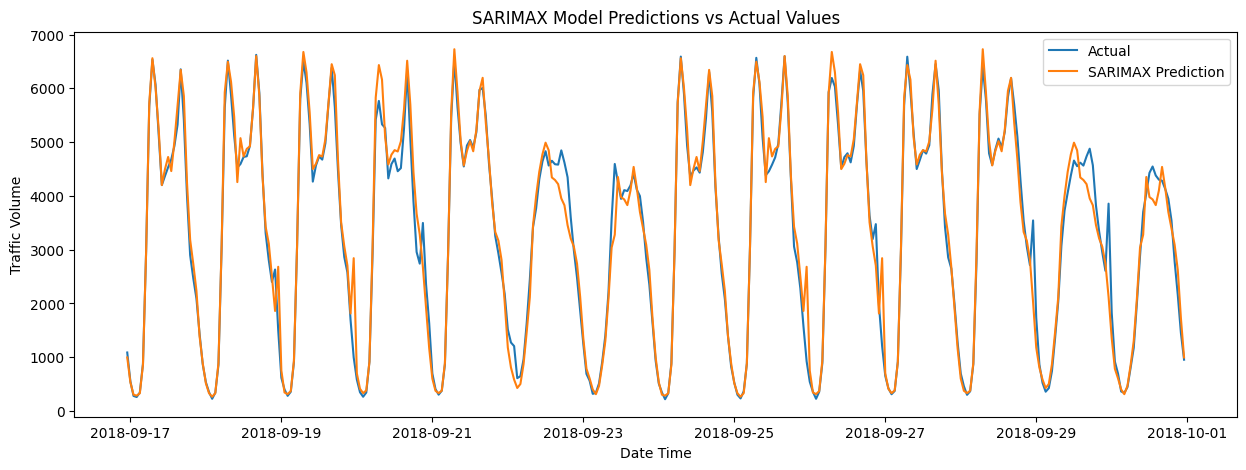

In [22]:
plot(sarima_pred, 'SARIMAX')

# LinearRegression

In [23]:
features = ['day_of_week', 'hour_of_day', 'temp', 'holiday']
for i in range(1, 25):
    features.append(f'lag_{i}')

X_train, X_test = train_data[features], test_data[features]
y_train, y_test = train_data['traffic_volume'], test_data['traffic_volume']

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

lr_pred = model.predict(X_test)

In [25]:
error(y_test, lr_pred)

MAE: 284.168335978832
MSE: 413.77704516242807


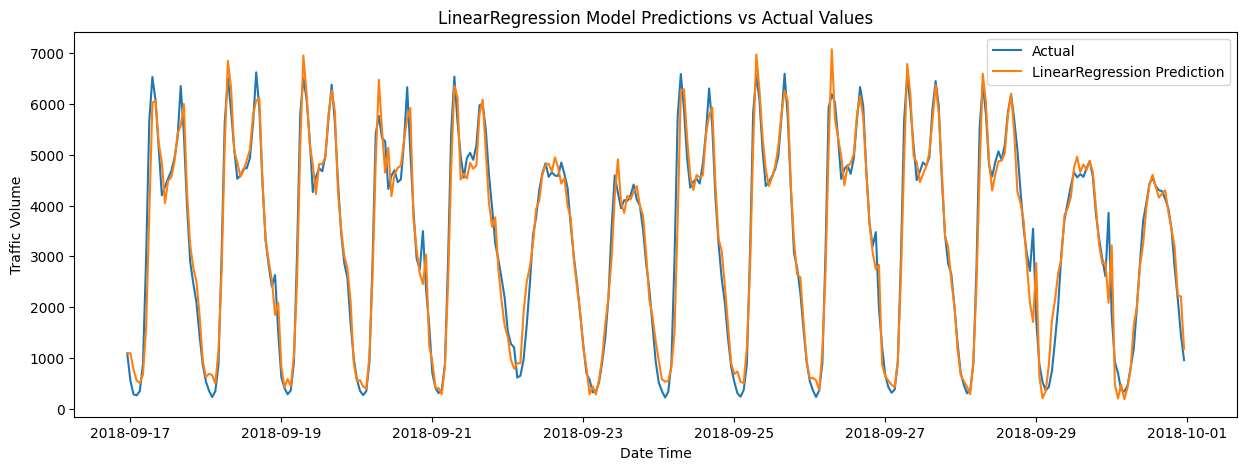

In [26]:
plot(lr_pred, 'LinearRegression')

# Boosting

In [27]:
import xgboost as xgb

model = xgb.XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

boosting_pred = model.predict(X_test)

In [28]:
error(y_test, boosting_pred)

MAE: 197.11177927803922
MSE: 280.74281022236977


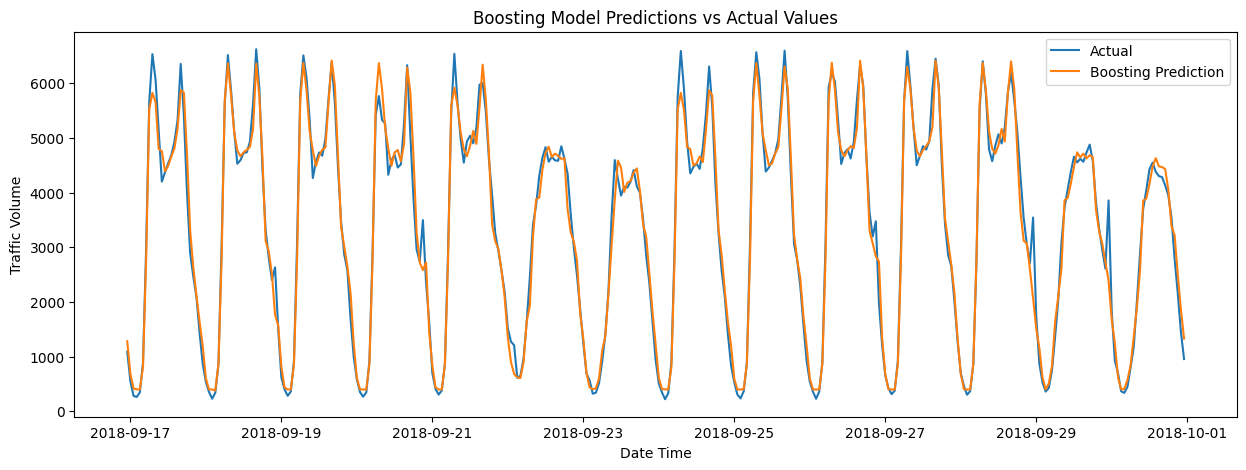

In [29]:
plot(boosting_pred, 'Boosting')

# LSTM

In [30]:
from sklearn.preprocessing import MinMaxScaler

lstm_features = ['traffic_volume'] + features

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[lstm_features])
scaled_test_data = scaler.transform(test_data[lstm_features])

X_train_lstm, y_train_lstm = np.array(scaled_train_data[:, 1:]), np.array(scaled_train_data[:, :1])
X_test_lstm, y_test_lstm = np.array(scaled_test_data[:, 1:]), np.array(scaled_test_data[:, :1])

X_train_lstm = X_train_lstm.reshape(( X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [31]:
def inverse_transform(prediction):
    return scaler.inverse_transform(np.concatenate((prediction, np.zeros((prediction.shape[0], len(features)))), axis=1))[:, 0]

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.2)

2024-08-07 10:09:07.280273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:09:07.380844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 10:09:07.391828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 10:09:07.610711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 10:09:12.126643: W tensorflow/compiler/tf2

Epoch 1/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0268 - val_loss: 0.0032
Epoch 2/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 3/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 4/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 9/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/20
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/20
1305/1305 ━━━━━━━━

In [33]:
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = inverse_transform(lstm_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [34]:
error(y_test, lstm_pred)

MAE: 167.3607358088833
MSE: 247.79670971939876


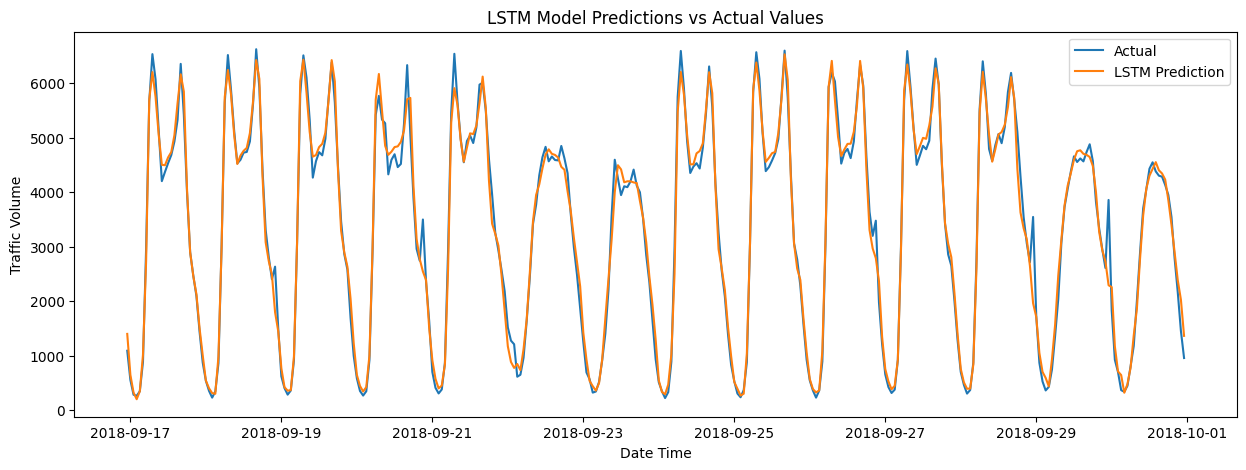

In [35]:
plot(lstm_pred, 'LSTM')

Предсказание на следующую неделю будем выпонять LSTM, т.к. она показала себя лучше всех.  
Для прогноза нам также придется предсказывать температуру.  
Поэтому в начале придется обучить SARIMAX предсказывать погоду

# SARIMAX для погоды

In [36]:
# уменьшим train т.к. не хватает оперативы

sarima_train_data = train_data['temp'][-1500:]

sarima_temp = SARIMAX(sarima_train_data, order=(0,0,0), seasonal_order=(0,1,0,24*7)).fit()

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61322D+00    |proj g|=  2.59887D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   3.503D-07   2.610D+00
  F =   2.6099608412289550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [37]:
temp_pred = sarima_temp.predict(start=len(sarima_train_data), end=len(sarima_train_data) + len(test_data)-1, dynamic=False)

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
error(test_data['temp'], temp_pred)

MAE: 11.011721068249258
MSE: 12.423369108257228


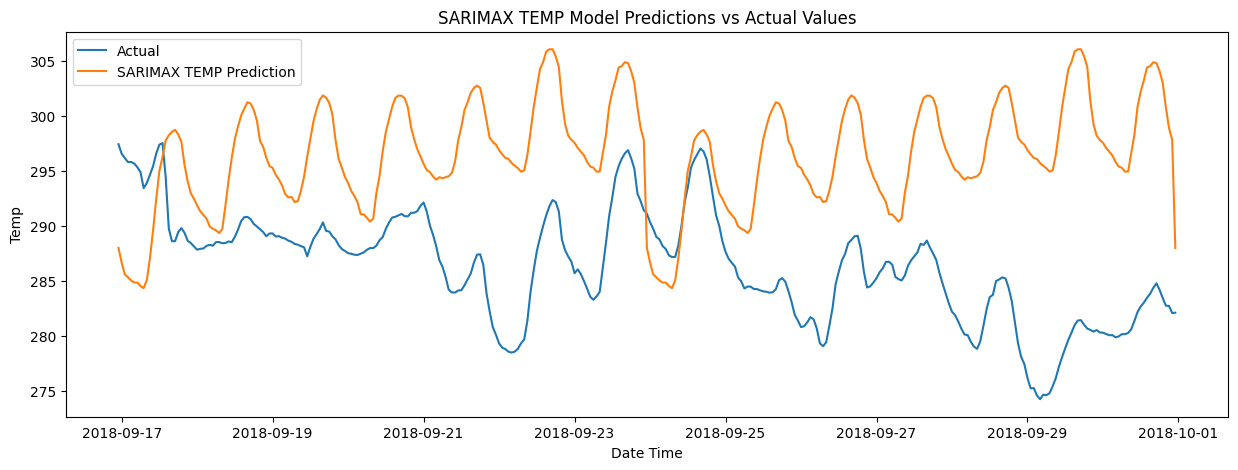

In [39]:
plot_temp(temp_pred, "SARIMAX TEMP")

Предсказываем температуру на неделю вперед

In [40]:
sarima_train_data = test_data['temp'][-1500:]

sarima_temp = SARIMAX(sarima_train_data, order=(0,0,0), seasonal_order=(0,1,0,24*7)).fit()

next_week_temp = sarima_temp.predict(start=len(sarima_train_data), end=len(sarima_train_data) + 24 * 7 - 1, dynamic=False)
next_week_temp = list(next_week_temp)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69527D+00    |proj g|=  1.15250D-01


 This problem is unconstrained.



At iterate    5    f=  1.61907D+00    |proj g|=  2.70135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6      7      1     0     0   2.251D-07   1.619D+00
  F =   1.6190661221809868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Функции для предсказания траффика на след неделю

In [41]:
input_features = ['traffic_volume','day_of_week', 'hour_of_day', 'temp', 'holiday']
input_lags = [f'lag_{i}' for i in range(1, 25)]
columns = input_features + input_lags

def changed_features(input, step):
    input_f = input[input_features]
    input_f['day_of_week'] = (input_f['day_of_week'] + 1) % 7
    input_f['hour_of_day'] = (input_f['hour_of_day'] + 1) % 24
    input_f['temp'] = next_week_temp[step]
    return np.array(input_f)

def changed_lags(input, pred):
    lags = np.array(input[input_lags])
    return np.append(lags[:, 1:], [pred], axis=1)

def preprocess_input(input):
    scaled_input = scaler.transform(input)
    scaled_input = np.array(scaled_input[:, 1:])
    return scaled_input.reshape(scaled_input.shape[0], 1, scaled_input.shape[1])

def predict_next_week():
    time_steps = 1 # возьмем последний час для предсказания
    steps_ahead = 24 * 7 # предсказываем на неделю вперед
    input = test_data[lstm_features][-time_steps:]

    predictions = []
    for step in range(steps_ahead):
        pred = lstm_model.predict(preprocess_input(input), verbose=False)
        pred_value = inverse_transform(pred)
        predictions.append(pred_value)
        input = np.append(changed_features(input, step), changed_lags(input, pred_value), axis=1)
        input = pd.DataFrame(input, columns=columns)
    return predictions

Функция для доверительных интервалов

In [42]:
def bootstrap_confidence_interval():
    lower_bound = np.percentile(test_data['traffic_volume'], 5)
    upper_bound = np.percentile(test_data['traffic_volume'], 95)

    return lower_bound, upper_bound

Предсказываем траффик и находим доверительные интервалы

In [43]:
next_week_traffic = predict_next_week()
lower_bound, upper_bound = bootstrap_confidence_interval()

Строим график прогнозов и доверительных интервалов

343.2 6189.0


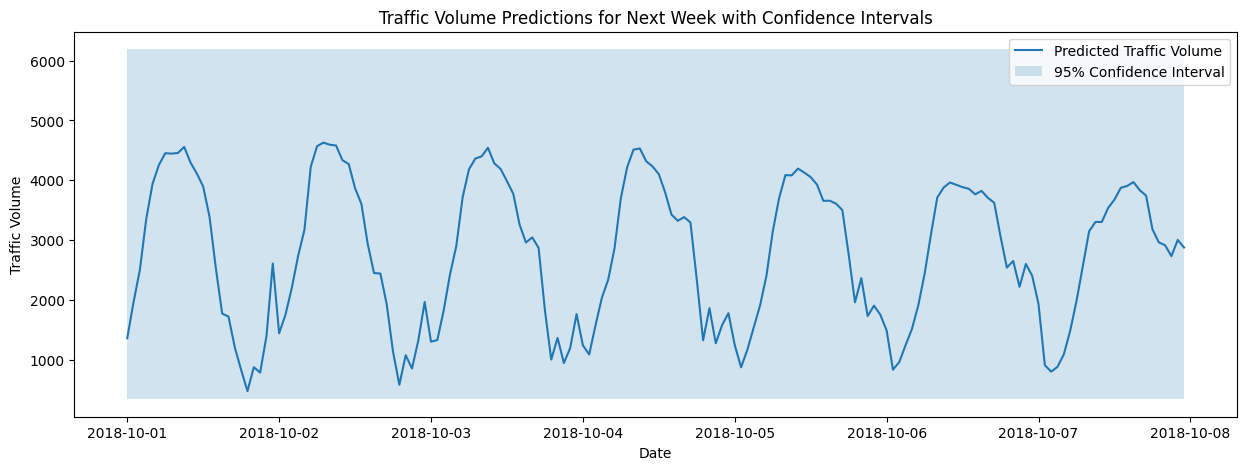

In [44]:
future_dates = pd.date_range(
    start=data['date_time'].max()+pd.Timedelta(hours=1),
    end=data['date_time'].max()+pd.Timedelta(weeks=1),
    freq='H'
)
print(lower_bound, upper_bound)
plt.figure(figsize=(15, 5))
plt.plot(future_dates, next_week_traffic, label='Predicted Traffic Volume')
plt.fill_between(future_dates, lower_bound, upper_bound, alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Predictions for Next Week with Confidence Intervals')
plt.show()

# Заключение

Наиболее лучше всего себя показала модель на основе LSTM.  
Не намного хуже себя показали модели SARIMAX и boosting.  
Недостатком SARIMAX является долгая настройка и время обучения.  
Также в SARIMAX невозможно передавать категориальные параметры.  
С помощью лучшей модели LSTM и SARIMAX (предсказывала температуру),  
был сделан прогноз траффика на неделю вперед, predict входит в рамки доверительного интервала